In [ ]:
# Combined NER Project: Enhanced BERT vs BERT + CRF with MC Dropout

In [2]:
## Section 1: Imports and Setup
import datasets
import typing as tp
from itertools import chain
from collections import defaultdict
import torch
from transformers import AutoModelForTokenClassification, AutoTokenizer, BertModel
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from seqeval.metrics import classification_report, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import seaborn as sns
import torch.nn as nn
from TorchCRF import CRF


In [3]:
device = torch.device("cpu")

In [4]:
## Section 2: Load and Preprocess Datasets
conll = datasets.load_dataset("conll2003")
wnut = datasets.load_dataset("wnut_17")

In [5]:
CONLL_NER_TAGS = conll['train'].features['ner_tags'].feature.names
WNUT_NER_TAGS = wnut['train'].features['ner_tags'].feature.names
label_mapping = {
    'O': 'O',
    'B-location': 'B-LOC', 'I-location': 'I-LOC',
    'B-group': 'B-ORG', 'B-corporation': 'B-ORG',
    'B-person': 'B-PER', 'I-person': 'I-PER',
    'B-creative-work': 'B-MISC', 'I-creative-work': 'I-MISC',
    'B-product': 'B-MISC', 'I-product': 'I-MISC',
    'I-corporation': 'I-ORG', 'I-group': 'I-ORG'
}
labelindexmapping = {WNUT_NER_TAGS.index(k): CONLL_NER_TAGS.index(v) for k, v in label_mapping.items()}
def convert_label_sequence(example, label_map):
    new_example = dict(**example)
    new_example['ner_tags'] = [label_map.get(tag, 0) for tag in example['ner_tags']]
    return new_example
converted_wnut = wnut.map(lambda x: convert_label_sequence(x, labelindexmapping))

In [6]:
## Section 3: Tokenization
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
def tokenize_and_preserve_tags(example, tokenizer, label2id, tokenizer_params={}):
    encoded = tokenizer(example["tokens"], is_split_into_words=True, return_offsets_mapping=True, **tokenizer_params)
    word_ids = encoded.word_ids()
    new_labels, new_text_labels = [], []
    prev_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            new_labels.append(-100)
            new_text_labels.append("O")
        else:
            label = example["ner_tags"][word_idx]
            tag_str = CONLL_NER_TAGS[label]
            if word_idx != prev_word_idx:
                new_labels.append(label2id[tag_str])
                new_text_labels.append(tag_str)
            else:
                tag_str = "I-" + tag_str[2:] if tag_str.startswith("B-") else tag_str
                new_labels.append(label2id[tag_str])
                new_text_labels.append(tag_str)
            prev_word_idx = word_idx
    encoded["labels"] = new_labels
    encoded["text_labels"] = new_text_labels
    return encoded

In [7]:
label2id = {tag: i for i, tag in enumerate(CONLL_NER_TAGS)}
conll = conll.map(lambda x: tokenize_and_preserve_tags(x, tokenizer, label2id))
wnut = converted_wnut.map(lambda x: tokenize_and_preserve_tags(x, tokenizer, label2id))

In [8]:
conll.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)
wnut.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'], output_all_columns=True)

In [9]:
class PadSequence:
    def __init__(self, padded_columns, device='cpu'):
        self.padded_columns = set(padded_columns)
        self.device = device
    def __call__(self, batch):
        padded_batch = defaultdict(list)
        for example in batch:
            for key, value in example.items():
                padded_batch[key].append(value)
        final_batch = {}
        for key, values in padded_batch.items():
            if isinstance(values[0], torch.Tensor):
                final_batch[key] = torch.nn.utils.rnn.pad_sequence(values, batch_first=True).to(self.device) if key in self.padded_columns else torch.stack(values).to(self.device)
            else:
                final_batch[key] = values
        return final_batch

In [10]:
collate_fn = PadSequence(['input_ids', 'token_type_ids', 'attention_mask', 'labels'], device=device)

In [11]:
## Section 4: Enhanced BERT NER Inference + Visualization
bert_model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER").to(device)
bert_tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [12]:
class NamedEntityPredictor:
    def __init__(self, model, tokenizer, id2label=None):
        self.model = model
        self.tokenizer = tokenizer
        self.id2label = model.config.id2label if id2label is None else id2label
    def predict(self, batch):
        self.model.eval()
        with torch.no_grad():
            output = self.model(input_ids=batch["input_ids"], token_type_ids=batch.get("token_type_ids"),
                                attention_mask=batch["attention_mask"], labels=batch.get("labels"), return_dict=True)
        indices = torch.argmax(output.logits, axis=2).detach().cpu().numpy()
        attention_mask = batch["attention_mask"].cpu().numpy()
        predicted_labels = [[self.id2label[int(idx)] for idx in indices[i][attention_mask[i] == 1]] for i in range(len(indices))]
        return {"predicted_labels": predicted_labels, "loss": output.loss, "logits": output.logits}

In [13]:
ner = NamedEntityPredictor(bert_model, bert_tokenizer)
conll_loader = torch.utils.data.DataLoader(conll["test"], batch_size=16, collate_fn=collate_fn)
wnut_loader = torch.utils.data.DataLoader(wnut["test"], batch_size=16, collate_fn=collate_fn)

In [14]:
predicted_labels = {"wnut_test": [], "conll_test": []}
for batch in tqdm(conll_loader, desc="Enhanced BERT Predicting CoNLL"):
    predicted_labels["conll_test"].extend(ner.predict(batch)["predicted_labels"])
for batch in tqdm(wnut_loader, desc="Enhanced BERT Predicting WNUT"):
    predicted_labels["wnut_test"].extend(ner.predict(batch)["predicted_labels"])

Enhanced BERT Predicting WNUT: 100%|██████████| 81/81 [02:00<00:00,  1.49s/it]


In [15]:
print("Enhanced BERT CoNLL Report\n", classification_report(y_true=[list(x["text_labels"]) for x in conll["test"]], y_pred=predicted_labels["conll_test"]))
print("Enhanced BERT WNUT Report\n", classification_report(y_true=[list(x["text_labels"]) for x in wnut["test"]], y_pred=predicted_labels["wnut_test"]))

Enhanced BERT CoNLL Report
               precision    recall  f1-score   support

         LOC       0.75      0.84      0.79      1668
        MISC       0.58      0.70      0.63       702
         ORG       0.71      0.82      0.76      1661
         PER       0.36      0.58      0.45      1617

   micro avg       0.58      0.74      0.65      5648
   macro avg       0.60      0.74      0.66      5648
weighted avg       0.61      0.74      0.66      5648

Enhanced BERT WNUT Report
               precision    recall  f1-score   support

         LOC       0.45      0.51      0.48       150
        MISC       0.17      0.22      0.19       269
         ORG       0.16      0.30      0.21       231
         PER       0.30      0.30      0.30       429

   micro avg       0.24      0.31      0.27      1079
   macro avg       0.27      0.33      0.29      1079
weighted avg       0.26      0.31      0.28      1079



100%|██████████| 41/41 [03:10<00:00,  4.65s/it]


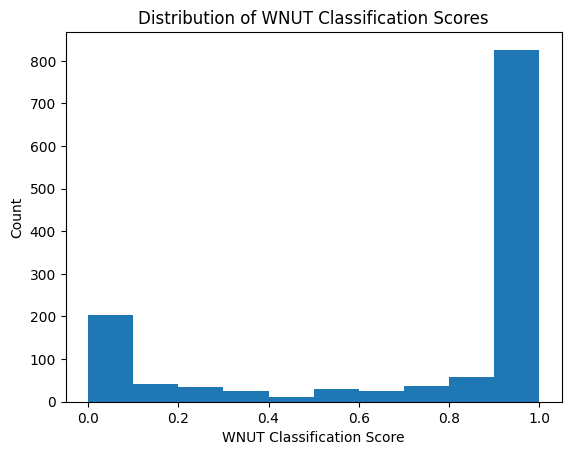

Score Range F1 Analysis
Score	F1
0.055	0.446
0.693	0.325
0.986	0.299
0.999	0.197
1.000	0.145


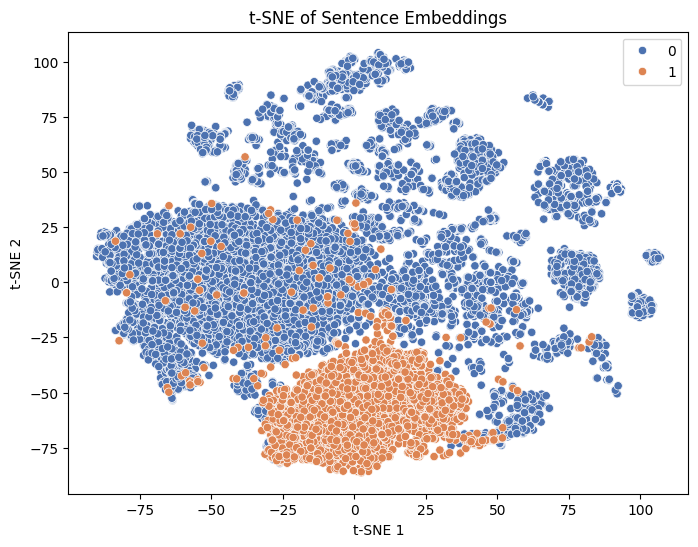

In [16]:
def get_sentence_embeddings(model, batch):
    model.eval()
    with torch.no_grad():
        return model.bert(input_ids=batch["input_ids"],
                          token_type_ids=batch["token_type_ids"],
                          attention_mask=batch["attention_mask"],
                          return_dict=True)["last_hidden_state"].cpu().numpy()[:, 0]

X, Y = [], []
for batch in tqdm(torch.utils.data.DataLoader(conll["train"], batch_size=32, collate_fn=collate_fn)):
    X.append(get_sentence_embeddings(bert_model, batch))
    Y.extend([0] * len(batch["input_ids"]))
for batch in tqdm(torch.utils.data.DataLoader(wnut["train"], batch_size=32, collate_fn=collate_fn)):
    X.append(get_sentence_embeddings(bert_model, batch))
    Y.extend([1] * len(batch["input_ids"]))

X = np.concatenate(X)
Y = np.array(Y)

classifier = LogisticRegression(max_iter=1000)
classifier.fit(X, Y)

# Uncertainty scoring and visualization
wnut_scores = []
for batch in tqdm(torch.utils.data.DataLoader(wnut["test"], batch_size=32, collate_fn=collate_fn)):
    x = get_sentence_embeddings(bert_model, batch)
    wnut_scores.append(classifier.predict_proba(x)[:, 1])
wnut_scores = np.concatenate(wnut_scores)

plt.hist(wnut_scores)
plt.xlabel("WNUT Classification Score")
plt.ylabel("Count")
plt.title("Distribution of WNUT Classification Scores")
plt.show()

# F1 by difficulty
sorted_indices = np.argsort(wnut_scores)
sorted_preds = np.array(predicted_labels["wnut_test"], dtype=object)[sorted_indices]
sorted_truth = np.array([example["text_labels"] for example in wnut["test"]], dtype=object)[sorted_indices]
score_splits = np.array_split(wnut_scores[sorted_indices], 5)
predicted_splits = np.array_split(sorted_preds, 5)
true_splits = np.array_split(sorted_truth, 5)

print("Score Range F1 Analysis")
print("Score\tF1")
for scores, true, pred in zip(score_splits, true_splits, predicted_splits):
    print(f"{np.mean(scores):.3f}\t{f1_score(true, pred):.3f}")

# t-SNE visualization
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=Y, palette='deep')
plt.title("t-SNE of Sentence Embeddings")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

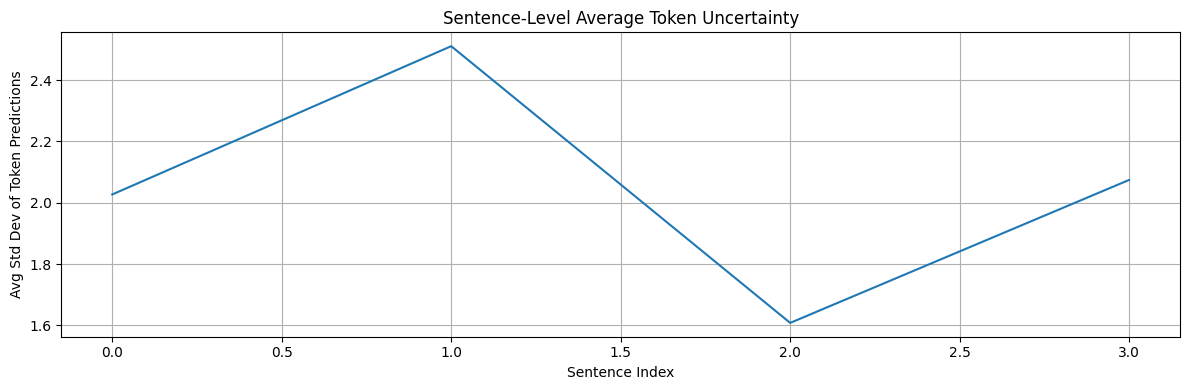

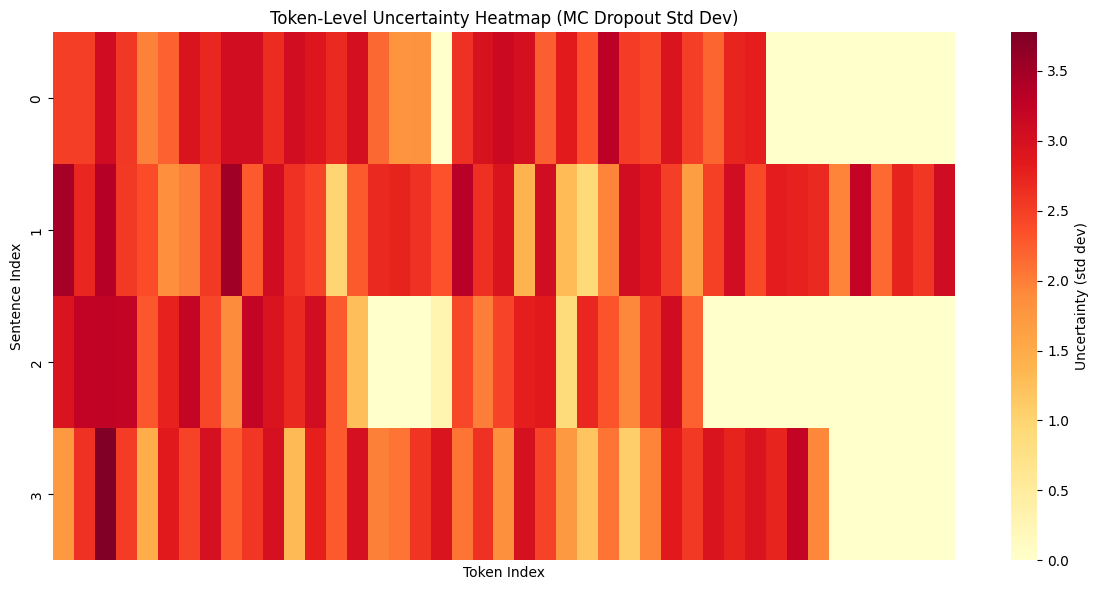

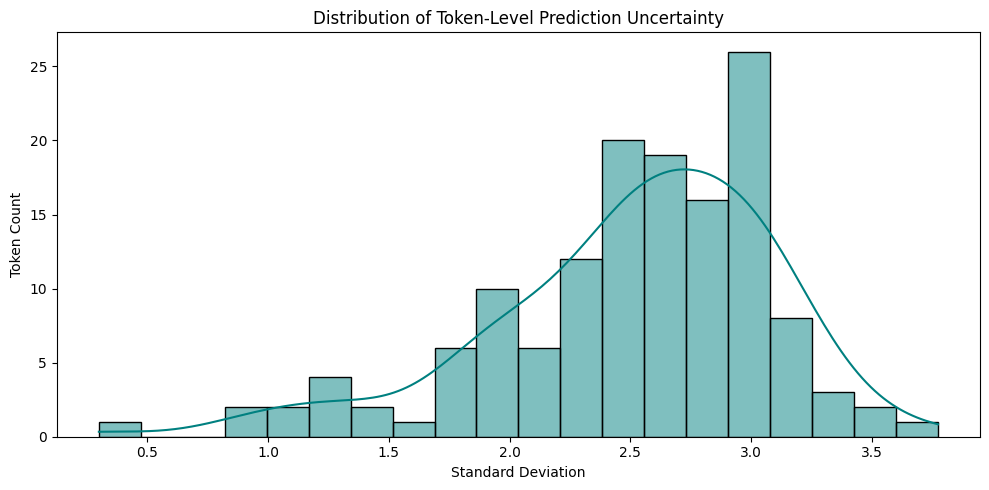

In [ ]:
# Define the BERT + CRF model
class BERT_CRF(nn.Module):
    def __init__(self, num_labels, dropout_prob=0.3):
        super(BERT_CRF, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased")
        self.dropout = nn.Dropout(dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask,
                            token_type_ids=token_type_ids)
        sequence_output = self.dropout(outputs[0])
        emissions = self.classifier(sequence_output)

        if labels is not None:
            loss = -self.crf(emissions, labels, mask=attention_mask.bool(), reduction='mean')
            return loss
        else:
            return self.crf.decode(emissions, mask=attention_mask.bool())

# Instantiate the model
crf_model = BERT_CRF(num_labels=len(label2id))

# MC Dropout inference function
def mc_dropout_predict(model, batch, n_iter=10):
    model.train()
    all_preds = []
    for _ in range(n_iter):
        with torch.no_grad():
            preds = model(input_ids=batch["input_ids"],
                          attention_mask=batch["attention_mask"],
                          token_type_ids=batch["token_type_ids"])
        all_preds.append(preds)
    model.eval()
    return all_preds

# Load test batch
test_loader = torch.utils.data.DataLoader(wnut["test"], batch_size=4, collate_fn=collate_fn)
batch = next(iter(test_loader))
predictions = mc_dropout_predict(crf_model, batch, n_iter=10)

# Prepare confidence data (token-level std deviation)
max_len = batch["input_ids"].shape[1]
num_sentences = len(batch["input_ids"])
token_stds = np.zeros((num_sentences, max_len))

# Pad predictions and compute std
for i in range(num_sentences):
    token_preds = []
    for iteration in predictions:
        sent_preds = iteration[i]
        # Pad if shorter than max_len
        padded = sent_preds + [-1] * (max_len - len(sent_preds))
        token_preds.append(padded)
    token_stds[i] = np.std(token_preds, axis=0)

# --------- Visualizations ---------

# 1. Std Dev Line Plot per Sentence
plt.figure(figsize=(12, 4))
plt.plot(np.mean(token_stds, axis=1))
plt.title("Sentence-Level Average Token Uncertainty")
plt.xlabel("Sentence Index")
plt.ylabel("Avg Std Dev of Token Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Heatmap of Token-Level Std Dev
plt.figure(figsize=(12, 6))
sns.heatmap(token_stds, cmap='YlOrRd', cbar_kws={"label": "Uncertainty (std dev)"}, xticklabels=False)
plt.title("Token-Level Uncertainty Heatmap (MC Dropout Std Dev)")
plt.xlabel("Token Index")
plt.ylabel("Sentence Index")
plt.tight_layout()
plt.show()

# 3. Histogram of All Token Uncertainty Values
plt.figure(figsize=(10, 5))
sns.histplot(token_stds[token_stds > 0], bins=20, kde=True, color='teal')
plt.title("Distribution of Token-Level Prediction Uncertainty")
plt.xlabel("Standard Deviation")
plt.ylabel("Token Count")
plt.tight_layout()
plt.show()
